<a href="https://colab.research.google.com/github/andysanch3z/Machine-Learning/blob/main/ML_AR_Uncollectibility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML development to predict probability of uncollectibility in customer invoices

## Data Pre-processing

### Libraries import

In [ ]:
!pip install --upgrade openpyxl
!pip install imbalanced-learn
!pip install lightgbm
!pip install shap --quiet
!pip install gradio --quiet
# Carga de datos y modelos
import os
import zipfile
import pickle
import joblib
from google.colab import drive
from datetime import datetime
# Procesamiento de datos
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy import sparse
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
from lightgbm import LGBMClassifier
import shap
# Visualización de datos
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from IPython.display import display
import seaborn as sns
import matplotlib.dates as mdates
# Prototipo
import gradio as gr
import traceback

### Data import

In [ ]:
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/MyDrive/ESPOL/TESIS/Data MCD.xlsx')

Mounted at /content/drive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186172 entries, 0 to 186171
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   customer_id                 186172 non-null  int64         
 1   invoice_no                  186172 non-null  object        
 2   invoice_date                186172 non-null  datetime64[ns]
 3   due_date                    186172 non-null  datetime64[ns]
 4   invoice_amount              186172 non-null  float64       
 5   term_days                   186172 non-null  int64         
 6   payment_date                178076 non-null  datetime64[ns]
 7   payment_amount              178076 non-null  float64       
 8   days_late                   186172 non-null  int64         
 9   num_prev_invoices           186172 non-null  int64         
 10  avg_prev_days_late          184725 non-null  float64       
 11  num_prev_late_invoices      184725 non-

## EDA (Exploratory Data Analysis)

### Data types

In [ ]:
# 2) Definir listas de columnas por tipo
categorical_cols = [
    'customer_id', 'invoice_no',
    'payment_terms_code', 'payment_method_code',
    'customer_group_code', 'state'
]

date_cols = [
    'invoice_date', 'due_date', 'payment_date',
    'prev_invoice_date'
]

float_cols = [
    'invoice_amount', 'payment_amount',
    'avg_prev_days_late', 'avg_prev_invoice_amount',
    'stddev_prev_invoice_amount', 'min_prev_invoice_amount',
    'max_prev_invoice_amount', 'ratio_invoice_to_avg',
    'pct_prev_paid_on_time', 'credit_limit1_effective',
    'credit_limit2_effective', 'credit_limit3_effective'
]

int_cols = [
    'term_days', 'days_late',
    'num_prev_invoices', 'num_prev_late_invoices',
    'num_prev_paid_1_30d', 'num_prev_paid_31_60d',
    'num_prev_paid_61_90d', 'sum_prev_days_late',
    'days_since_last_invoice'
]

# 3) Convertir tipos

# Categóricas
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Fechas
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Flotantes
for col in float_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)

# Enteros con soporte NA
for col in int_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

# 4) Verificar
print(df.dtypes)

customer_id                         category
invoice_no                          category
invoice_date                  datetime64[ns]
due_date                      datetime64[ns]
invoice_amount                       float64
term_days                              Int64
payment_date                  datetime64[ns]
payment_amount                       float64
days_late                              Int64
num_prev_invoices                      Int64
avg_prev_days_late                   float64
num_prev_late_invoices                 Int64
num_prev_paid_1_30d                    Int64
num_prev_paid_31_60d                   Int64
num_prev_paid_61_90d                   Int64
sum_prev_days_late                     Int64
avg_prev_invoice_amount              float64
stddev_prev_invoice_amount           float64
min_prev_invoice_amount              float64
max_prev_invoice_amount              float64
prev_invoice_date             datetime64[ns]
days_since_last_invoice                Int64
ratio_invo

### Customer analysis

#### Customer late invoices

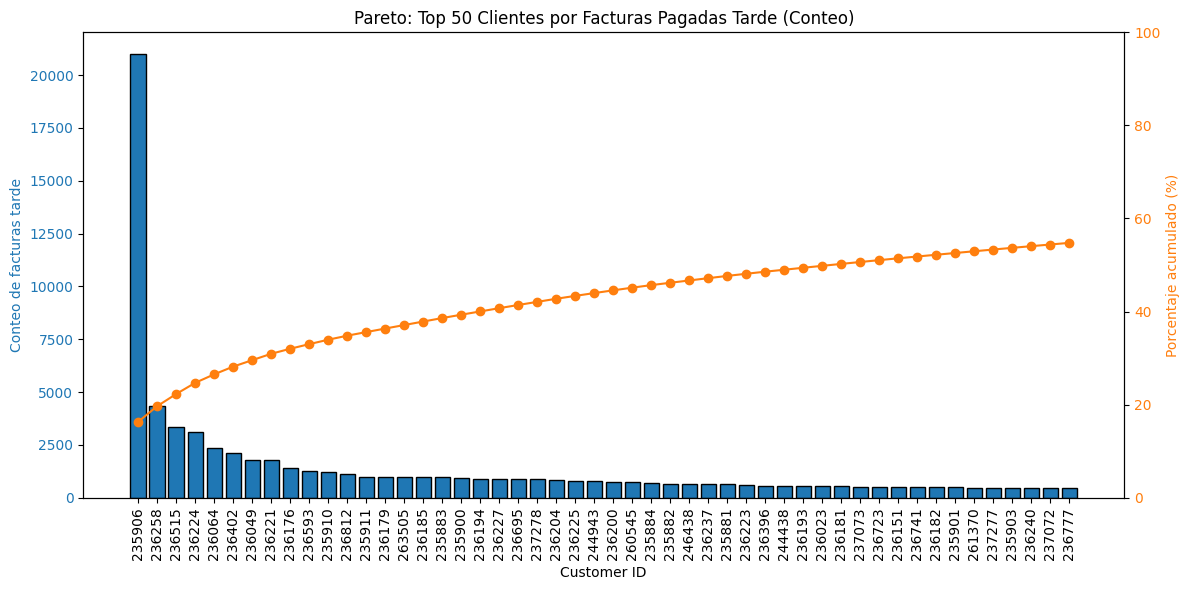

In [ ]:
# 1) Top N
top_n = 50

# 2A) Late invoices count
late_counts = df[df['days_late'] > 0]['customer_id'].value_counts()
top_late_counts = late_counts.head(top_n)
cum_perc_counts = top_late_counts.cumsum() / late_counts.sum() * 100

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(top_late_counts.index.astype(str), top_late_counts.values, color='C0', edgecolor='k')
ax1.set_xlabel('Customer ID')
ax1.set_ylabel('Conteo de facturas tarde', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
plt.xticks(rotation=90)

ax2 = ax1.twinx()
ax2.plot(top_late_counts.index.astype(str), cum_perc_counts.values, color='C1', marker='o')
ax2.set_ylabel('Porcentaje acumulado (%)', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_ylim(0, 100)

plt.title(f'Pareto: Top {top_n} Clientes por Facturas Pagadas Tarde (Conteo)')
plt.tight_layout()
plt.show()

#### Late invoices days

    days_late  count      cum_%
0           1  10255   7.967524
1           3   9513  15.358558
2           7   8842  22.228265
3           4   7939  28.396395
4           2   7787   34.44643
5           6   7436  40.223759
6           5   6302  45.120037
7           8   5778  49.609199
8           9   4121   52.81097
9          10   4068  55.971564
10         14   3587  58.758449
11         11   3550  61.516588
12         13   3081  63.910341
13         12   2793  66.080336
14         15   2307  67.872737
15         17   1997  69.424287
16         18   1996   70.97506
17         21   1936  72.479217
18         16   1722  73.817108
19         20   1464  74.954549
20         19   1330   75.98788
21         22   1288  76.988579
22         24   1288  77.989278
23         25   1163   78.89286
24         28   1153  79.788672
25         27   1016  80.578044
26         23    974  81.334784
27         35    959  82.079869
28         32    872  82.757362
29         26    806  83.383575
30      

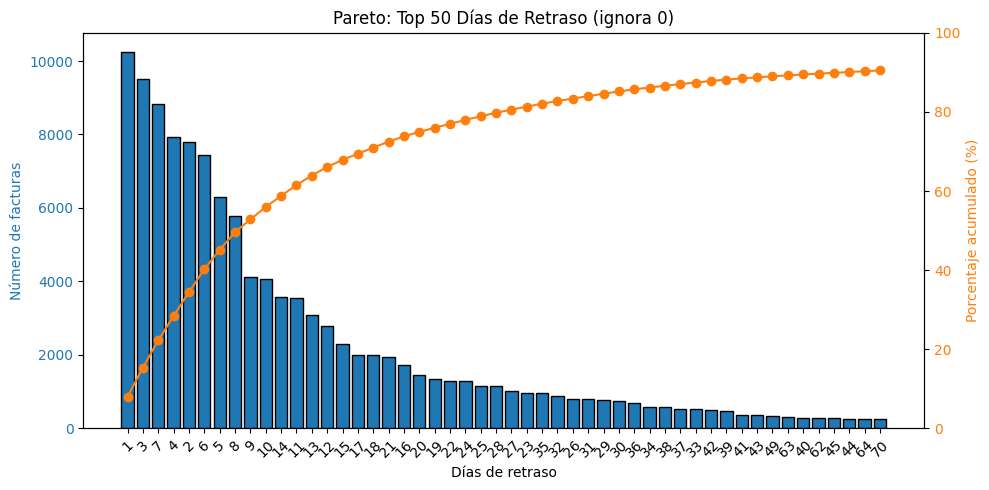

In [ ]:
# 1) Filtrar días de retraso > 0
late_days = df.loc[df['days_late'] > 0, 'days_late']

# 2) Calcular frecuencia y ordenar
freq = late_days.value_counts().sort_values(ascending=False)

# 3) Top N días más frecuentes
top_n = 50
top_freq = freq.head(top_n)

# 4) Porcentaje acumulado
cum_perc = top_freq.cumsum() / freq.sum() * 100

# 5) Mostrar tabla con conteo y acumulado
print(pd.DataFrame({
    'days_late':  top_freq.index,
    'count':      top_freq.values,
    'cum_%':      cum_perc.values
}))

# 6) Graficar Pareto
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(top_freq.index.astype(str), top_freq.values, color='C0', edgecolor='k')
ax1.set_xlabel('Días de retraso')
ax1.set_ylabel('Número de facturas', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax2.plot(top_freq.index.astype(str), cum_perc.values, color='C1', marker='o')
ax2.set_ylabel('Porcentaje acumulado (%)', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_ylim(0,100)

plt.title(f'Pareto: Top {top_n} Días de Retraso (ignora 0)')
plt.tight_layout()
plt.show()

#### Perc 90

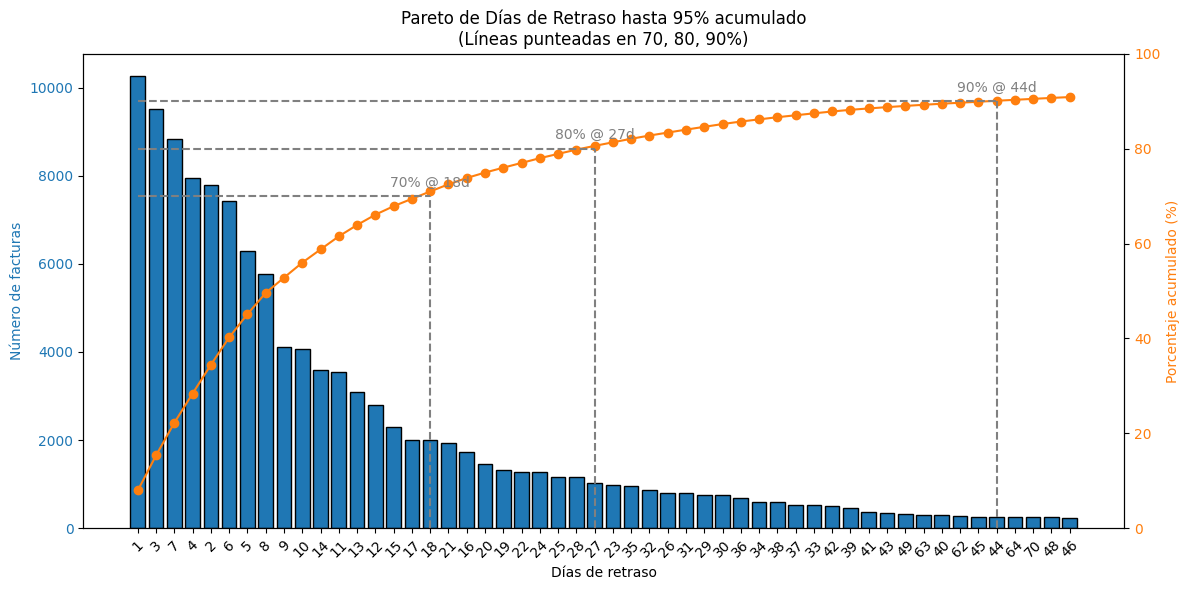

In [ ]:
# 1) Filtrar days_late > 0 y calcular frecuencias
late_days = df.loc[df['days_late'] > 0, 'days_late']
freq = late_days.value_counts().sort_values(ascending=False)

# 2) Calcular porcentaje acumulado
cum_perc = freq.cumsum() / freq.sum() * 100

# 3) Filtrar hasta 95%
mask = cum_perc <= 91
freq_cut = freq[mask]
cum_cut  = cum_perc[mask]
days_cut = freq_cut.index.astype(str)
pos      = range(len(freq_cut))

# 4) Identificar cruces de 70, 80, 90 sobre la serie completa
thresholds = [70, 80, 90]
cross_days = {thr: cum_perc[cum_perc >= thr].index[0] for thr in thresholds}
cross_pos  = {thr: list(freq_cut.index).index(cross_days[thr]) for thr in thresholds}

# 5) Graficar Pareto acotado al 95%
fig, ax1 = plt.subplots(figsize=(12,6))

# Barras
ax1.bar(pos, freq_cut.values, color='C0', edgecolor='k')
ax1.set_xlabel('Días de retraso')
ax1.set_ylabel('Número de facturas', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
ax1.set_xticks(pos)
ax1.set_xticklabels(days_cut, rotation=45)

# Línea acumulada
ax2 = ax1.twinx()
ax2.plot(pos, cum_cut.values, color='C1', marker='o', linestyle='-')
ax2.set_ylabel('Porcentaje acumulado (%)', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_ylim(0, 100)

# 6) Dibujar líneas punteadas para 70%, 80%, 90%
for thr in thresholds:
    p = cross_pos[thr]
    # horizontal line
    ax2.hlines(thr, xmin=0, xmax=p, colors='gray', linestyles='--')
    # vertical line
    ax2.vlines(p, ymin=0, ymax=thr, colors='gray', linestyles='--')
    # etiqueta
    ax2.text(p, thr + 2, f'{thr}% @ {cross_days[thr]}d', color='gray', ha='center')

plt.title('Pareto de Días de Retraso hasta 95% acumulado\n(Líneas punteadas en 70, 80, 90%)')
plt.tight_layout()
plt.show()

In [ ]:
# 1) Filtrar sólo días_late>0
late = df.loc[df['days_late']>0, 'days_late']

# 2) Calcular el percentil 80
threshold_80 = int(late.quantile(0.80))
print(f"Percentil 80 de days_late: {threshold_80} días")

# 3) Crear la etiqueta target
df['label_default_80'] = (df['days_late'] > threshold_80).astype(int)

Percentil 80 de days_late: 26 días


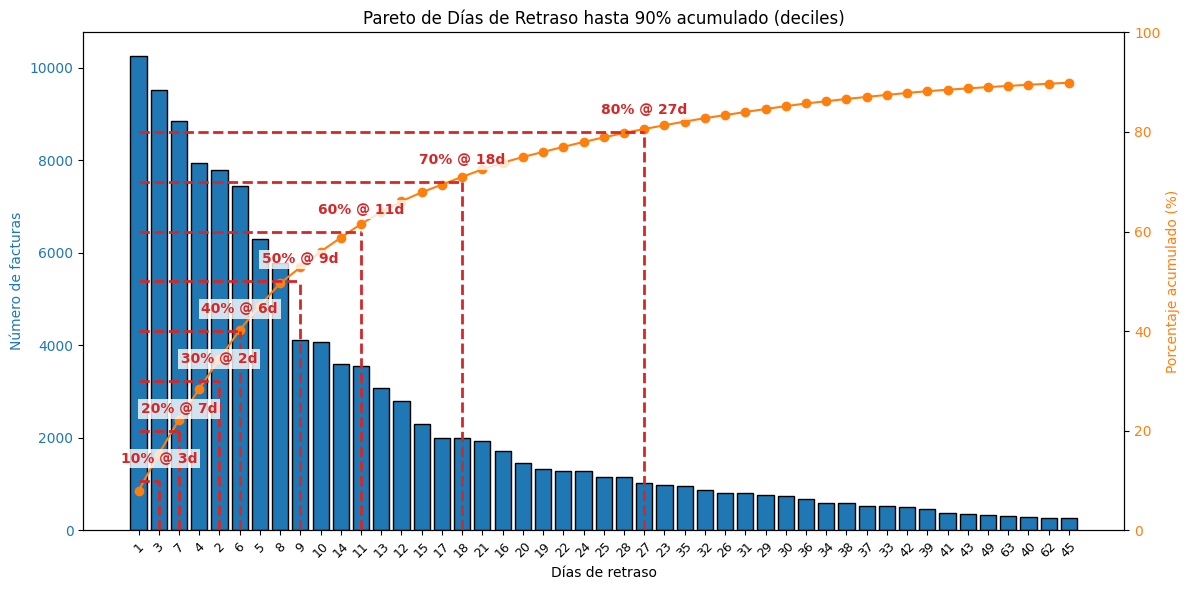

In [ ]:
# 1) Filtrar days_late > 0 y calcular frecuencias (completo)
late_days = df.loc[df['days_late'] > 0, 'days_late']
freq_full = late_days.value_counts().sort_values(ascending=False)
cum_full  = freq_full.cumsum() / freq_full.sum() * 100

# 2) Acotar al 90% acumulado
mask      = cum_full <= 90
freq_cut  = freq_full[mask]
cum_cut   = cum_full[mask]
days_cut  = freq_cut.index.astype(str)
pos_cut   = np.arange(len(freq_cut))

# 3) Deciles (10,20,…,90) y posiciones en la curva completa
deciles   = list(range(10, 100, 10))
cross_day = {d: cum_full[cum_full >= d].index[0] for d in deciles}
cross_pos = {
    d: list(freq_cut.index).index(cross_day[d])
    for d in deciles
    if cross_day[d] in freq_cut.index
}

# 4) Graficar Pareto acotado al 90%
fig, ax1 = plt.subplots(figsize=(12,6))

# Barras
ax1.bar(pos_cut, freq_cut.values, color='#1f77b4', edgecolor='k')
ax1.set_xticks(pos_cut)
ax1.set_xticklabels(days_cut, rotation=45, fontsize=9)
ax1.set_xlabel('Días de retraso')
ax1.set_ylabel('Número de facturas', color='#1f77b4')
ax1.tick_params(axis='y', labelcolor='#1f77b4')

# Línea acumulada
ax2 = ax1.twinx()
ax2.plot(pos_cut, cum_cut.values, color='#ff7f0e', marker='o', linestyle='-')
ax2.set_ylabel('Porcentaje acumulado (%)', color='#ff7f0e')
ax2.tick_params(axis='y', labelcolor='#ff7f0e')
ax2.set_ylim(0, 100)

# 5) Dibujar líneas punteadas con alto contraste y etiquetas
line_color = '#d62728'
for d, p in cross_pos.items():
    ax2.hlines(d, xmin=0, xmax=p,
               colors=line_color,
               linestyles='--',
               linewidth=2)
    ax2.vlines(p, ymin=0, ymax=d,
               colors=line_color,
               linestyles='--',
               linewidth=2)
    ax2.text(p, d + 3,
             f'{d}% @ {cross_day[d]}d',
             color=line_color,
             fontweight='bold',
             ha='center',
             va='bottom',
             bbox={'facecolor':'white','edgecolor':'none','alpha':0.8, 'pad':2})

plt.title('Pareto de Días de Retraso hasta 90% acumulado (deciles)')
plt.tight_layout()
plt.show()

#### Aging curve

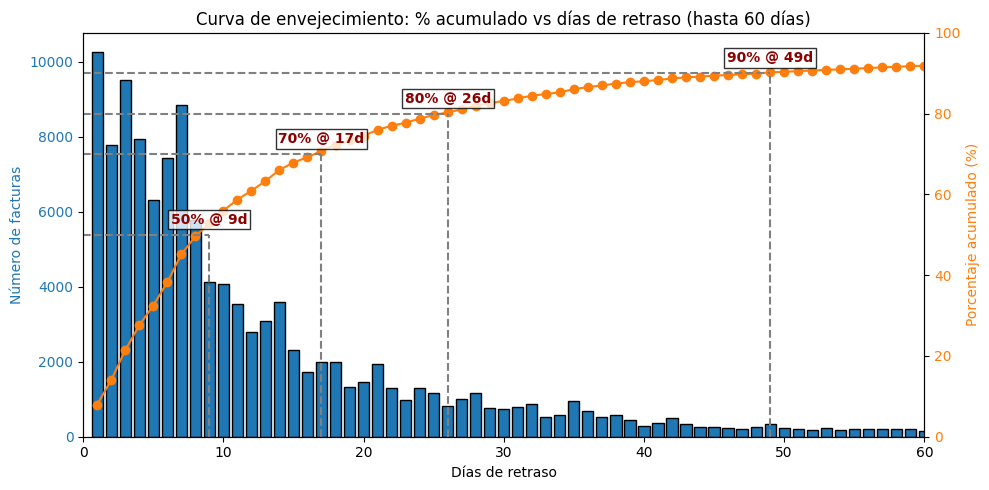

In [ ]:
# 1) Distribución por día de retraso (>0), ordenada ascendente
dist = (
    df.loc[df['days_late'] > 0, 'days_late']
      .value_counts()
      .sort_index()
)

# 2) Curva acumulada de porcentaje
cum_perc = dist.cumsum() / dist.sum() * 100

# 3) Acotar al rango de 1 a 60 días
max_day = 60
dist_cut = dist[dist.index <= max_day]
cum_cut  = cum_perc[dist_cut.index]

# 4) Graficar curva de envejecimiento hasta 60 días
fig, ax1 = plt.subplots(figsize=(10, 5))

# — Barras de frecuencia —
ax1.bar(dist_cut.index, dist_cut.values, color='C0', edgecolor='k')
ax1.set_xlim(0, max_day)
ax1.set_xlabel('Días de retraso')
ax1.set_ylabel('Número de facturas', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

# — Línea acumulada (%) —
ax2 = ax1.twinx()
ax2.plot(cum_cut.index, cum_cut.values, color='C1', marker='o', linestyle='-')
ax2.set_ylabel('Porcentaje acumulado (%)', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_ylim(0, 100)
ax2.set_xlim(0, max_day)

# 5) Líneas punteadas para percentiles clave (50, 70, 80, 90) dentro de 60 días
for p in [50, 70, 80, 90]:
    # primer día donde el acumulado >= p
    day = cum_perc[cum_perc >= p].index[0]
    if day <= max_day:
        ax2.hlines(p, 0, day, colors='gray', linestyles='--', linewidth=1.5)
        ax2.vlines(day, 0, p, colors='gray', linestyles='--', linewidth=1.5)
        ax2.text(day, p+2, f'{p}% @ {day}d',
                 ha='center', va='bottom',
                 color='darkred', fontweight='bold',
                 bbox={'facecolor':'white','alpha':0.8,'pad':2})

plt.title('Curva de envejecimiento: % acumulado vs días de retraso (hasta 60 días)')
plt.tight_layout()
plt.show()

#### Invoice due date range pie chart

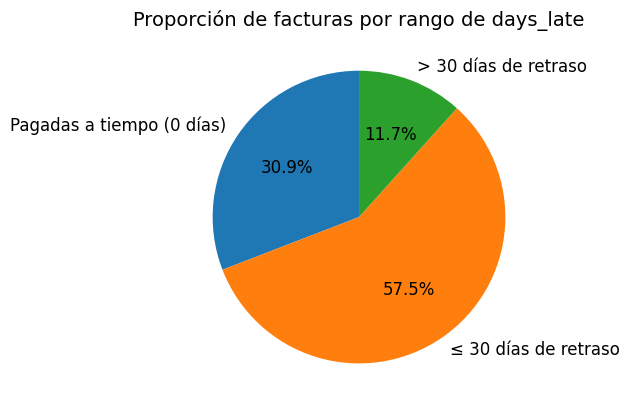

In [ ]:
# 1) Calcular las categorías
on_time = (df['days_late'] == 0).sum()
late_30 = df['days_late'].between(1, 30).sum()
late_over_30 = (df['days_late'] > 30).sum()

# 2) Preparar datos para el pastel
counts = [on_time, late_30, late_over_30]
labels = [
    'Pagadas a tiempo (0 días)',
    '≤ 30 días de retraso',
    '> 30 días de retraso'
]

# 3) Graficar pie chart
plt.figure(figsize=(6,6))
plt.pie(
    counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12}
)
plt.title('Proporción de facturas por rango de days_late', fontsize=14)
plt.tight_layout()
plt.show()

#### RFM

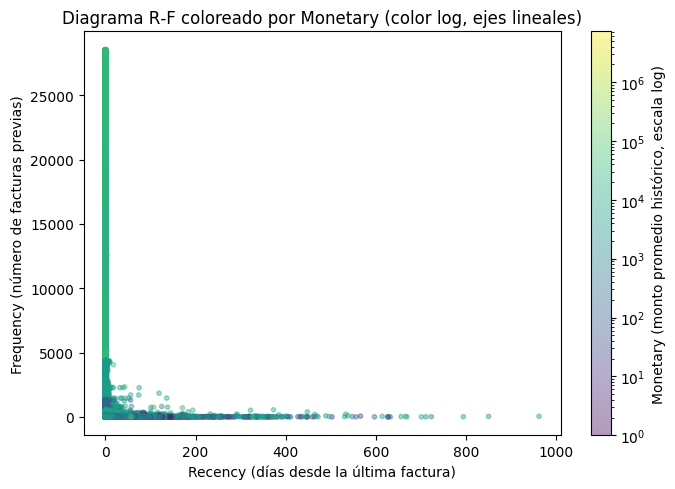

In [ ]:
# 1) Opcional: reducir la muestra para agilizar el plot

# 2) Definir las series R, F y M
R = df['days_since_last_invoice']
F = df['num_prev_invoices']
M = df['avg_prev_invoice_amount']

# 3) Scatter plot con ejes lineales y color en escala logarítmica
plt.figure(figsize=(7,5))
sc = plt.scatter(
    R,
    F,
    c=M,
    cmap='viridis',
    norm=LogNorm(vmin=1, vmax=df['avg_prev_invoice_amount'].max()),
    s=10,       # tamaño pequeño para mayor nitidez
    alpha=0.4   # transparencia para ver densidades
)

# 4) Barra de color
cbar = plt.colorbar(sc)
cbar.set_label('Monetary (monto promedio histórico, escala log)')

# 5) Ejes lineales
plt.xscale('linear')
plt.yscale('linear')

# 6) Etiquetas y título
plt.xlabel('Recency (días desde la última factura)')
plt.ylabel('Frequency (número de facturas previas)')
plt.title('Diagrama R‑F coloreado por Monetary (color log, ejes lineales)')

plt.tight_layout()
plt.show()


/tmp/ipython-input-29-3288497307.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  rf_matrix = pd.pivot_table(


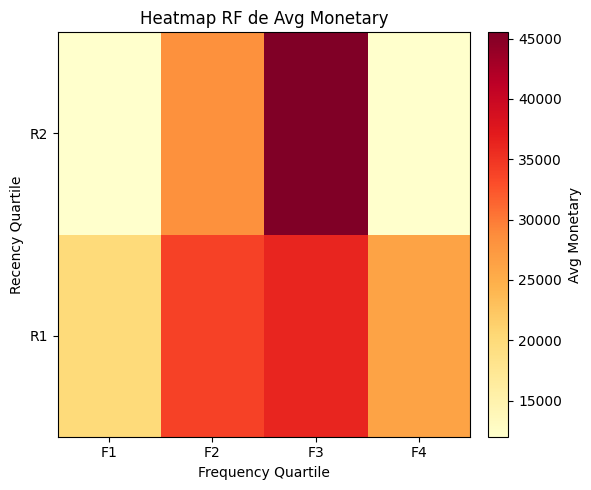

In [ ]:
# 1) Discretizar en cuartiles (sin labels fijos)
r_bins = pd.qcut(df['days_since_last_invoice'], 4, duplicates='drop')
f_bins = pd.qcut(df['num_prev_invoices'],       4, duplicates='drop')

# 2) Crear un DataFrame auxiliar que sólo contenga filas válidas
mask = r_bins.notna() & f_bins.notna()
df_aux = df.loc[mask].copy()
r_bins = r_bins[mask]
f_bins = f_bins[mask]

# 3) Pivot table: promedio de Monetary en cada combinación de recency/frequency
rf_matrix = pd.pivot_table(
    data=df_aux,
    index=r_bins,
    columns=f_bins,
    values='avg_prev_invoice_amount',   # <- usar el nombre de la columna, no la serie
    aggfunc='mean'
)
# 4) Graficar el heatmap
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(rf_matrix, origin='lower', cmap='YlOrRd', aspect='auto')

# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Avg Monetary')

# Etiquetas
ax.set_xticks(range(rf_matrix.shape[1]))
ax.set_xticklabels([f'F{q+1}' for q in range(rf_matrix.shape[1])])
ax.set_yticks(range(rf_matrix.shape[0]))
ax.set_yticklabels([f'R{q+1}' for q in range(rf_matrix.shape[0])])

ax.set_xlabel('Frequency Quartile')
ax.set_ylabel('Recency Quartile')
ax.set_title('Heatmap RF de Avg Monetary')
plt.tight_layout()
plt.show()


#### Label balance

In [ ]:
counts = df['label_default'].value_counts().sort_index()  # index 0,1
labels = ['Pagada','Impaga']
values = [counts[0], counts[1]]

plt.figure(figsize=(6,4))
plt.bar(labels, values, color=['green','red'])
plt.title('Proporción de facturas pagadas vs impagas')
plt.ylabel('Número de facturas')
plt.tight_layout()
plt.show()

KeyError: 'label_default'

In [ ]:
# 2) Boxplot de invoice_amount por clase ABC (escala log)
grouped = df[['ABC_class','invoice_amount']].copy()
# Filtra clases que te interesen (opcional)
allowed = ['A','B','C','D','E','Desconocido']
grouped = grouped[grouped['ABC_class'].isin(allowed)]

plt.figure(figsize=(8,5))
plt.yscale('log')
plt.boxplot(
    [grouped.loc[grouped['ABC_class']==c, 'invoice_amount'] for c in allowed],
    labels=allowed,
    showfliers=False
)
plt.title('Distribución de invoice_amount por clase ABC (escala log)')
plt.xlabel('Clase ABC')
plt.ylabel('Monto de factura (log)')
plt.tight_layout()
plt.show()


KeyError: "['ABC_class'] not in index"

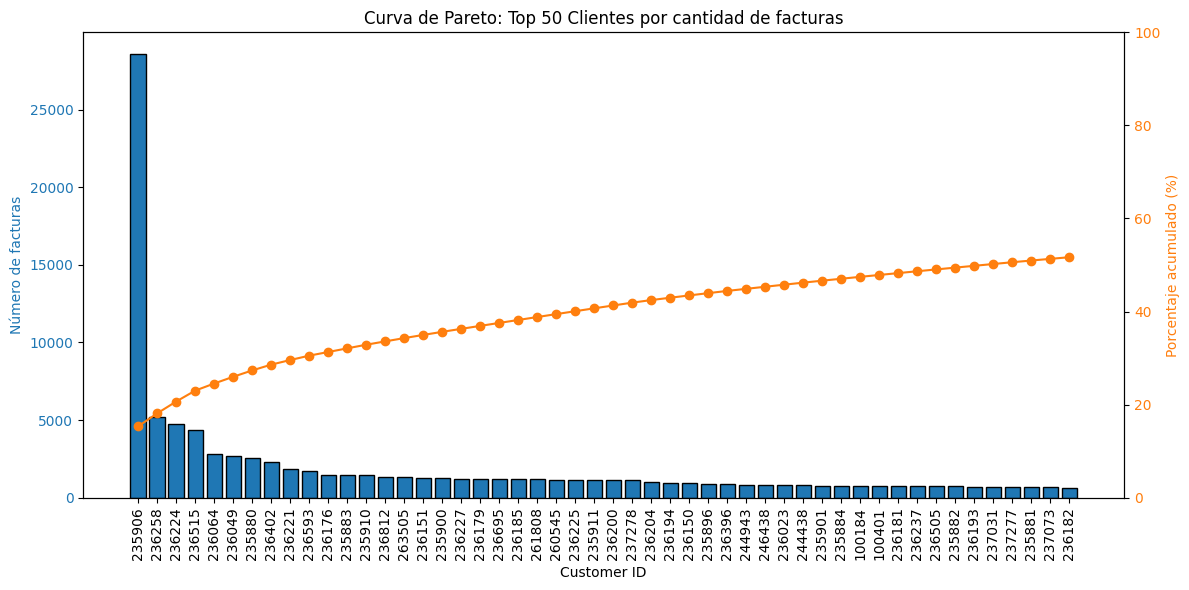

In [ ]:
# 1) Calcular número de facturas por cliente y ordenar de mayor a menor
invoice_counts = df['customer_id'].value_counts()

# 2) Seleccionar solo el Top N clientes
top_n = 50
top_counts = invoice_counts.nlargest(top_n)

# 3) Cálculo del porcentaje acumulado respecto al total de facturas
cum_perc = top_counts.cumsum() / invoice_counts.sum() * 100

# 4) Gráfico de Pareto sin "Others"
fig, ax1 = plt.subplots(figsize=(12, 6))

# Barras (conteo)
ax1.bar(top_counts.index.astype(str),
        top_counts.values,
        color='C0',
        edgecolor='k')
ax1.set_xlabel('Customer ID')
ax1.set_ylabel('Número de facturas', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
plt.xticks(rotation=90)

# Línea de porcentaje acumulado
ax2 = ax1.twinx()
ax2.plot(top_counts.index.astype(str),
         cum_perc.values,
         color='C1',
         marker='o',
         linestyle='-')
ax2.set_ylabel('Porcentaje acumulado (%)', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_ylim(0, 100)

plt.title(f'Curva de Pareto: Top {top_n} Clientes por cantidad de facturas')
plt.tight_layout()
plt.show()

/tmp/ipython-input-14-3072270724.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('customer_id')['invoice_amount']


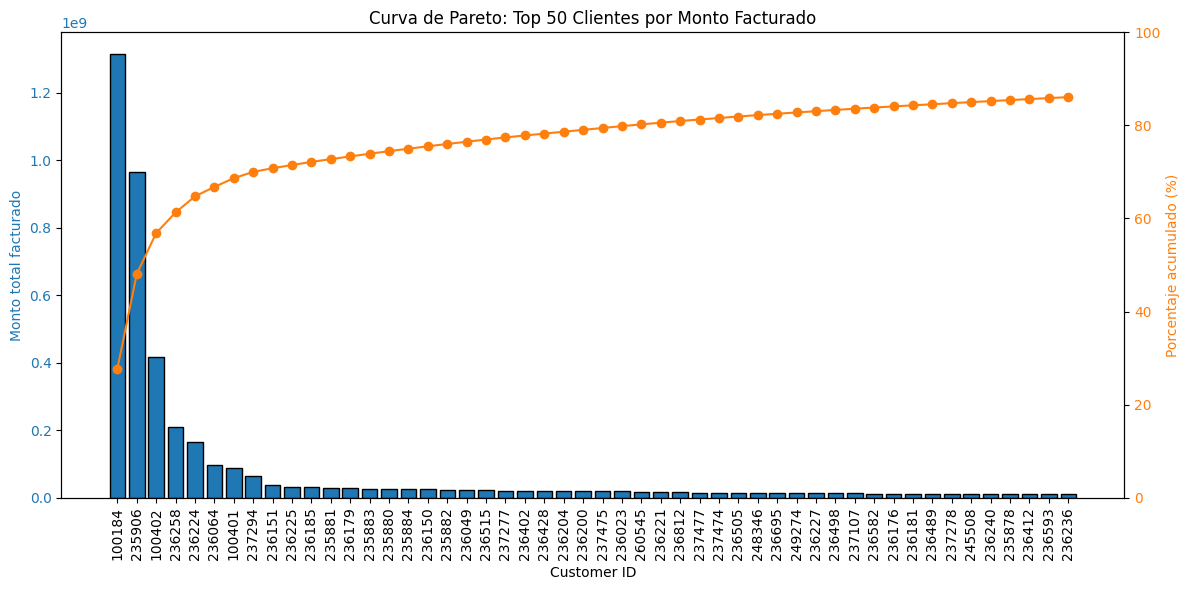

In [ ]:
# 1) Sumar invoice_amount por customer
amount_by_customer = (
    df.groupby('customer_id')['invoice_amount']
      .sum()
      .sort_values(ascending=False)
)

# 2) Top N clientes
top_n = 50
top_amounts = amount_by_customer.head(top_n)

# 3) Cálculo de porcentaje acumulado sobre el total
cum_perc = top_amounts.cumsum() / amount_by_customer.sum() * 100

# 4) Graficar Pareto por monto facturado
fig, ax1 = plt.subplots(figsize=(12, 6))

# Barras con monto
ax1.bar(top_amounts.index.astype(str),
        top_amounts.values,
        color='C0',
        edgecolor='k')
ax1.set_xlabel('Customer ID')
ax1.set_ylabel('Monto total facturado', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
plt.xticks(rotation=90)

# Línea de porcentaje acumulado
ax2 = ax1.twinx()
ax2.plot(top_amounts.index.astype(str),
         cum_perc.values,
         color='C1',
         marker='o',
         linestyle='-')
ax2.set_ylabel('Porcentaje acumulado (%)', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_ylim(0, 100)

plt.title(f'Curva de Pareto: Top {top_n} Clientes por Monto Facturado')
plt.tight_layout()
plt.show()

### target definition

In [ ]:
# 1) Crear indicador de factura tarde
df['is_late'] = (df['days_late'] > 0).astype(int)

# 2) Resumen global On-Time vs Late
summary = pd.DataFrame({
    'total_invoices': [len(df)],
    'late_invoices':  [df['is_late'].sum()]
})
summary['late_rate_%'] = summary['late_invoices'] / summary['total_invoices'] * 100
print("=== Resumen general ===")
display(summary)

=== Resumen general ===


,total_invoices,late_invoices,late_rate_%
0,186172,128710,69.134993


In [ ]:
df['label_default'] = (df['days_late'] > 30).astype(int)

### Nan values

In [ ]:
# 2.2 Detección de valores faltantes
print("\nValores faltantes por columna:")
display(df.isnull().sum())


Valores faltantes por columna:


,0
customer_id,0
invoice_no,0
invoice_date,0
due_date,0
invoice_amount,0
term_days,0
payment_date,8096
payment_amount,8096
days_late,0
num_prev_invoices,0


In [ ]:
# 1) Historial de clientes: imputar a 0 donde falta
history_feats = [
    'num_prev_invoices','avg_prev_days_late','num_prev_late_invoices',
    'num_prev_paid_1_30d','num_prev_paid_31_60d','num_prev_paid_61_90d',
    'sum_prev_days_late','avg_prev_invoice_amount','stddev_prev_invoice_amount',
    'min_prev_invoice_amount','max_prev_invoice_amount',
    'prev_invoice_date','days_since_last_invoice',
    'ratio_invoice_to_avg','pct_prev_paid_on_time', 'label_default_80'
]

# Para métricas numéricas, rellenar NaN → 0
num_metrics = history_feats.copy()
num_metrics.remove('prev_invoice_date')  # fecha la tratamos aparte

df[num_metrics] = df[num_metrics].fillna(0)

# Para prev_invoice_date, imputar con invoice_date
df['prev_invoice_date'] = df['prev_invoice_date'].fillna(df['invoice_date'])

# 2) Pagos faltantes: ya hiciste payment_amount=0, pero asegúrate:
df['payment_amount'] = df['payment_amount'].fillna(0)

In [ ]:
# 2.2 Detección de valores faltantes
print("\nValores faltantes por columna:")
display(df.isnull().sum())


Valores faltantes por columna:


,0
customer_id,0
invoice_no,0
invoice_date,0
due_date,0
invoice_amount,0
term_days,0
payment_date,8096
payment_amount,0
days_late,0
num_prev_invoices,0


#### Unpaid invoices

count                             8096
mean     2025-02-18 20:10:33.201581312
min                2022-06-20 00:00:00
25%                2025-03-13 00:00:00
50%                2025-04-23 00:00:00
75%                2025-05-25 00:00:00
max                2025-06-16 00:00:00
Name: invoice_date, dtype: object


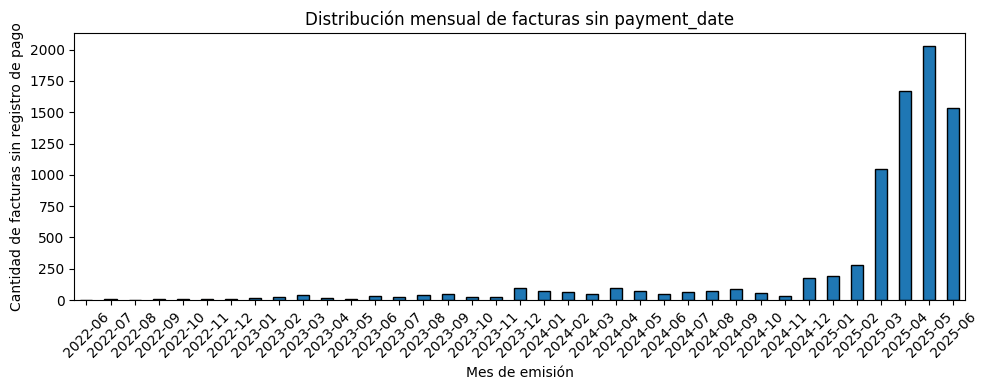

In [ ]:
# Después ejecuta el bloque de validación:
mask_new = df['payment_date'].isna()
new_invoices = df.loc[mask_new, 'invoice_date']

print(new_invoices.describe())

monthly_counts = new_invoices.dt.to_period('M').value_counts().sort_index()
plt.figure(figsize=(10,4))
monthly_counts.plot(kind='bar', edgecolor='k')
plt.xlabel('Mes de emisión')
plt.ylabel('Cantidad de facturas sin registro de pago')
plt.title('Distribución mensual de facturas sin payment_date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Las facturas sin payment date son relativamente nuevas. Por tanto eliminaremos el payment date ya que tenemos el flag de is late y el days_late. Agregaremos otras variables relacionadas a las fechas.

Cutoff (max invoice_date): 2025-06-16

Resumen de invoice_date para facturas sin pago:
count                             8096
mean     2025-02-18 20:10:33.201581312
min                2022-06-20 00:00:00
25%                2025-03-13 00:00:00
50%                2025-04-23 00:00:00
75%                2025-05-25 00:00:00
max                2025-06-16 00:00:00
Name: invoice_date, dtype: object


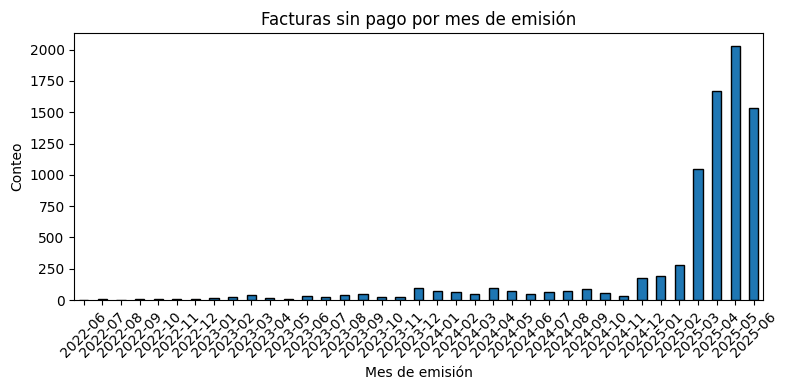

,invoice_date,due_date,payment_date,payment_date_imputed,days_to_payment,paid_before_due
0,2025-04-01,2025-06-13,2025-04-08,2025-04-08,7,1
1,2023-12-20,2024-02-14,2024-06-07,2024-06-07,170,0
2,2023-12-24,2024-02-14,2024-06-07,2024-06-07,166,0
3,2024-01-24,2024-03-15,2024-03-12,2024-03-12,48,1
4,2024-05-28,2024-07-15,2024-06-07,2024-06-07,10,1
5,2024-05-28,2024-07-15,2024-06-07,2024-06-07,10,1
6,2024-05-28,2024-07-15,2024-06-24,2024-06-24,27,1
7,2024-05-28,2024-07-15,2024-06-24,2024-06-24,27,1
8,2024-05-28,2024-07-15,2024-06-24,2024-06-24,27,1
9,2024-05-28,2024-07-15,2024-06-24,2024-06-24,27,1


In [ ]:
# 1) Definir cutoff como la fecha máxima de emisión de factura
cutoff = df['invoice_date'].max()
print(f"Cutoff (max invoice_date): {cutoff.date()}")

# 2) Validar fechas de facturas sin payment_date y su relación con cutoff
new_mask = df['payment_date'].isna()
new_issues = df.loc[new_mask, 'invoice_date']

# Estadísticos de esas fechas
print("\nResumen de invoice_date para facturas sin pago:")
print(new_issues.describe())

# Histograma mensual
monthly = new_issues.dt.to_period('M').value_counts().sort_index()
plt.figure(figsize=(8,4))
monthly.plot(kind='bar', edgecolor='k')
plt.title('Facturas sin pago por mes de emisión')
plt.xlabel('Mes de emisión')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3) Imputar payment_date faltantes a cutoff
df['payment_date_imputed'] = df['payment_date'].fillna(cutoff)

# 4) Calcular días hasta pago
df['days_to_payment'] = (df['payment_date_imputed'] - df['invoice_date']).dt.days

# 5) Flag pago antes de vencimiento
df['paid_before_due'] = (df['payment_date_imputed'] <= df['due_date']).astype(int)

# 6) Mostrar primeras filas para verificar
display(df[['invoice_date','due_date','payment_date','payment_date_imputed',
            'days_to_payment','paid_before_due']].head(10))


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186172 entries, 0 to 186171
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   customer_id                 186172 non-null  category      
 1   invoice_no                  186172 non-null  category      
 2   invoice_date                186172 non-null  datetime64[ns]
 3   due_date                    186172 non-null  datetime64[ns]
 4   invoice_amount              186172 non-null  float64       
 5   term_days                   186172 non-null  Int64         
 6   payment_date                178076 non-null  datetime64[ns]
 7   payment_amount              186172 non-null  float64       
 8   days_late                   186172 non-null  Int64         
 9   num_prev_invoices           186172 non-null  Int64         
 10  avg_prev_days_late          186172 non-null  float64       
 11  num_prev_late_invoices      186172 non-

Agregamos otras variables de interés

In [ ]:
# 1) Aging‐buckets sobre days_late
bins   = [-1, 0, 30, 60, 90, np.inf]
labels = ['on_time','1_30','31_60','61_90','over_90']
df['bucket_late'] = pd.cut(df['days_late'], bins=bins, labels=labels)

# 1.1) (Opcional) dummies para cada bucket
for lab in labels:
    df[f'bucket_{lab}'] = (df['bucket_late'] == lab).astype(int)

# 2) Última fecha de pago **anterior** a cada factura
#    (shift + cummax para quedarnos con el pago más reciente **previo**)
df['last_pay_date'] = (
    df
    .sort_values(['customer_id','invoice_date'])
    .groupby('customer_id')['payment_date']
    .apply(lambda x: x.shift().cummax())
    .reset_index(level=0, drop=True)
)

# 3) Recencia de pago: días desde ese last_pay_date hasta la emisión
df['days_since_last_pay'] = (
    (df['invoice_date'] - df['last_pay_date'])
    .dt.days
    .fillna(-1)     # usamos -1 para indicar “nunca antes pagó”
    .astype(int)
)

/tmp/ipython-input-53-2013772197.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('customer_id')['payment_date']


In [ ]:
df.isna().sum()

,0
customer_id,0
invoice_no,0
invoice_date,0
due_date,0
invoice_amount,0
term_days,0
payment_date,8096
payment_amount,0
days_late,0
num_prev_invoices,0


In [ ]:
df = df.drop(columns=['payment_date','last_pay_date'])

In [ ]:
# 1) Columnas a soltar (ahora quitamos también la señal de “pagada tarde” y los buckets)
drop_cols = [
    'customer_id',
    'invoice_no',
    'invoice_date',
    'due_date',
    'prev_invoice_date',
    'payment_date_imputed',
    # variables que derivan directamente del pago (leakage)
    'days_late',
    'payment_amount',
    'days_to_payment',
    'paid_before_due',
    'is_late',           # la señal 0/1 de si hubo demora — ¡leak!
    'bucket_late',
    'bucket_on_time',
    'bucket_1_30',
    'bucket_31_60',
    'bucket_61_90',
    'bucket_over_90',
     'label_default_80'
]
X = df.drop(columns=drop_cols + ['label_default'])
y = df['label_default'].astype(int)

#### Correlation

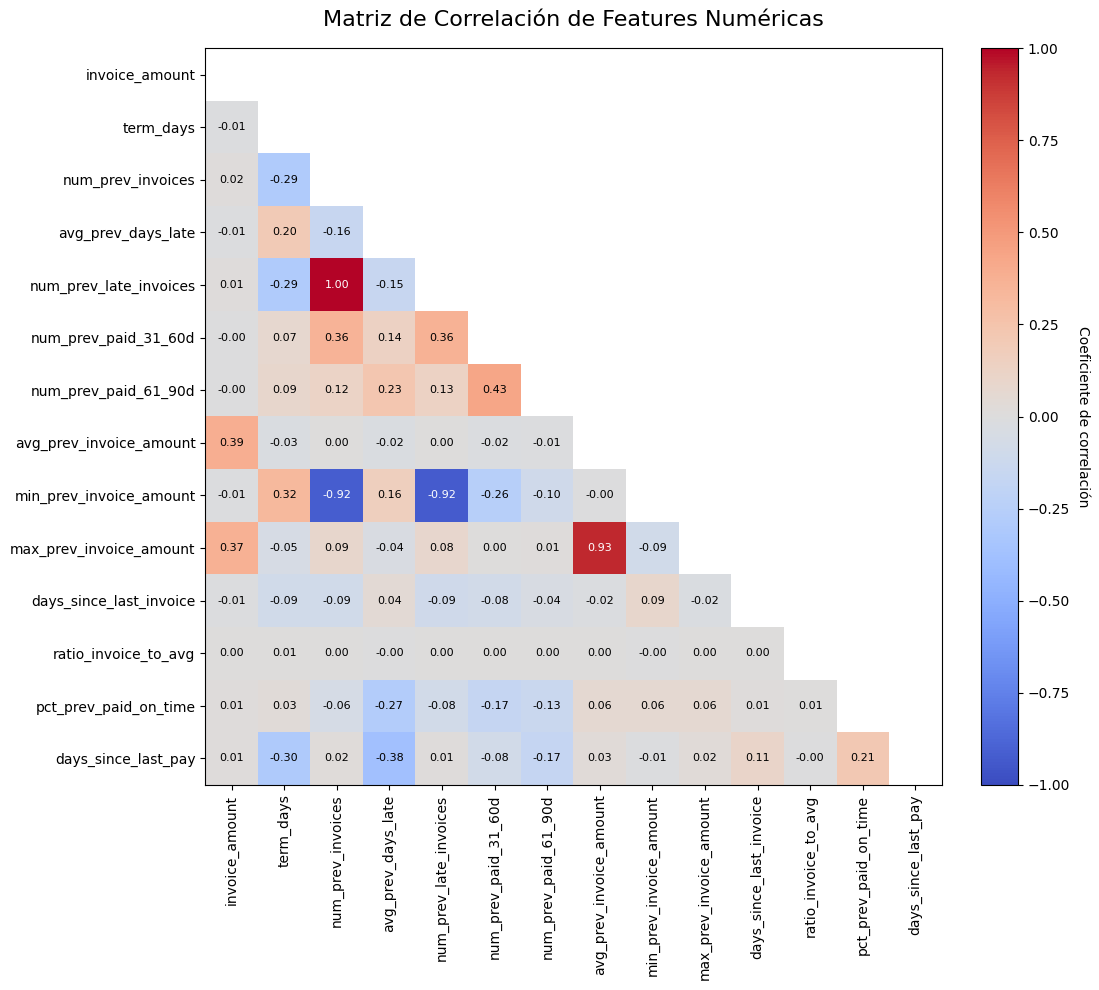

In [ ]:
# 1) Selecciona solo las columnas numéricas
num_cols = X.select_dtypes(include=['int64','Int64','float64']).columns
corr = X[num_cols].corr().values

# 2) Crea la máscara para ocultar el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# 3) Enmascara la parte superior
corr_masked = np.ma.masked_where(mask, corr)

# 4) Dibuja el heatmap
fig, ax = plt.subplots(figsize=(12,10))
cmap = plt.get_cmap('coolwarm')

# Muestra la matriz enmascarada
im = ax.imshow(corr_masked, cmap=cmap, vmin=-1, vmax=1)

# 5) Añade colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Coeficiente de correlación', rotation=-90, va="bottom")

# 6) Ajusta ticks y etiquetas
ax.set_xticks(np.arange(len(num_cols)))
ax.set_yticks(np.arange(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=90)
ax.set_yticklabels(num_cols)

# 7) Anota los valores en cada celda
for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        if not mask[i, j]:
            text = f"{corr[i, j]:.2f}"
            ax.text(j, i, text,
                    ha="center", va="center",
                    color="black" if abs(corr[i, j]) < 0.5 else "white",
                    fontsize=8)

# 8) Título y layout
ax.set_title('Matriz de Correlación de Features Numéricas', fontsize=16, pad=16)
plt.tight_layout()
plt.show()


In [ ]:
# 1) Eliminamos las columnas con correlación alta
drop_cols = [
    'num_prev_paid_1_30d',
    'sum_prev_days_late'
    ,'stddev_prev_invoice_amount'
]
X = X.drop(columns=drop_cols)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186172 entries, 0 to 186171
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   invoice_amount              186172 non-null  float64
 1   term_days                   186172 non-null  Int64  
 2   num_prev_invoices           186172 non-null  Int64  
 3   avg_prev_days_late          186172 non-null  float64
 4   num_prev_late_invoices      186172 non-null  Int64  
 5   num_prev_paid_31_60d        186172 non-null  Int64  
 6   num_prev_paid_61_90d        186172 non-null  Int64  
 7   avg_prev_invoice_amount     186172 non-null  float64
 8   stddev_prev_invoice_amount  186172 non-null  float64
 9   min_prev_invoice_amount     186172 non-null  float64
 10  max_prev_invoice_amount     186172 non-null  float64
 11  days_since_last_invoice     186172 non-null  Int64  
 12  ratio_invoice_to_avg        186172 non-null  float64
 13  pct_prev_paid_

## Preprocessing

#### Model Saver

In [ ]:
# 0) Model‐saver
SAVE_DIR = '/content/drive/My Drive/PrototipoTesis/saved_models'
os.makedirs(SAVE_DIR, exist_ok=True)

def save_model(estimator, name):
    ts   = datetime.now().strftime("%Y%m%d_%H%M%S")
    path = os.path.join(SAVE_DIR, f"{name}_{ts}.pkl")
    joblib.dump(estimator, path)
    print(f"✅ `{name}` guardado en:\n   {path}\n")

### Preprocessor definition

In [ ]:
# 2) Definición de features
numeric_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = [
    'payment_terms_code',
    'payment_method_code',
    'customer_group_code',
    'state'
]

# Aseguramos que X_train/test sean string para OneHotEncoder
X[categorical_features] = X[categorical_features].astype(str)

In [ ]:
# 3) Split temporal
cutoff     = pd.to_datetime('2023-01-01')
mask_train = df['invoice_date'] < cutoff

X_train, X_test = X.loc[mask_train], X.loc[~mask_train]
y_train, y_test = y[mask_train], y[~mask_train]

In [ ]:
# 4) Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
                 categorical_features),
    ],
    remainder='drop',
    n_jobs=-1
)

preprocessor.fit(X_train)

# opcional: imprime cuántas dummies generó
n_num = len(numeric_features)
n_cat = preprocessor.named_transformers_['cat'] \
                   .get_feature_names_out(categorical_features).shape[0]
print(f"Numeric feats: {n_num},  OHE‐dummies: {n_cat}")

Numeric feats: 15,  OHE‐dummies: 52


In [ ]:
# Porcentajes directos
y_train.value_counts(normalize=True).mul(100).round(1)

,proportion
label_default,
0,89.6
1,10.4


## Model training

#### Logistic Regression

In [ ]:
# 5) Pipeline
pipe = ImbPipeline([
    ('pre',   preprocessor),                     # estandariza + OHE
    ('smote', SMOTE(random_state=42)),           # solo en train
    ('clf',   LogisticRegression(
                  random_state=42,
                  max_iter=10_000
              )),
])

In [ ]:
# 6) Grid de parámetros
param_grid = {
    'clf__C':       [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver':  ['liblinear','saga'],
}

In [ ]:
# 7) Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# 8) GridSearch
gs_lr = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
print("► Entrenando LogisticRegression con CV temporal…")
gs_lr.fit(X_train, y_train)

print("🔍 Mejores hiperparámetros:", gs_lr.best_params_)
print("🏆 Mejor CV AUC:      ", gs_lr.best_score_)

► Entrenando LogisticRegression con CV temporal…
Fitting 5 folds for each of 8 candidates, totalling 40 fits
🔍 Mejores hiperparámetros: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
🏆 Mejor CV AUC:       0.8396347148370026


In [ ]:
# 9) Evaluación
y_proba = gs_lr.predict_proba(X_test)[:,1]
y_pred  = (y_proba >= 0.5).astype(int)

print("\n▶️ Test ROC AUC:", roc_auc_score(y_test, y_proba))
print("\n📊 Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\n📈 Classification report:\n", classification_report(y_test, y_pred))


▶️ Test ROC AUC: 0.809283873730788

📊 Matriz de confusión:
 [[92831 35813]
 [ 4178 13362]]

📈 Classification report:
               precision    recall  f1-score   support

           0       0.96      0.72      0.82    128644
           1       0.27      0.76      0.40     17540

    accuracy                           0.73    146184
   macro avg       0.61      0.74      0.61    146184
weighted avg       0.87      0.73      0.77    146184



In [ ]:
# 7) Guardado del mejor modelo
save_model(gs_lr.best_estimator_, 'logistic_regression')

✅ `logistic_regression` guardado en:
   /content/drive/My Drive/PrototipoTesis/saved_models/logistic_regression_20250714_154320.pkl



In [ ]:
def save_model(estimator, name):
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    path = os.path.join(SAVE_DIR, f"{name}_{ts}.pkl")
    joblib.dump(estimator, path)
    print(f"✅ `{name}` guardado en:\n   {path}\n")

#### Decision Tree

In [ ]:
print("► Entrenando Decision Tree")
pipe_dt = ImbPipeline([
    ('pre',   preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf',   DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    'clf__max_depth':        [5, 10, 20, None],
    'clf__min_samples_split':[2, 5, 10],
    'clf__min_samples_leaf': [1, 3, 5]
}

tscv = TimeSeriesSplit(n_splits=5)
gs_dt = GridSearchCV(pipe_dt,
                     param_grid_dt,
                     cv=tscv,
                     scoring='roc_auc',
                     n_jobs=-1,
                     verbose=1)

gs_dt.fit(X_train, y_train)
print("Mejores hiperparámetros DT:", gs_dt.best_params_)
print("Mejor CV AUC DT:", gs_dt.best_score_)

y_pred_proba = gs_dt.predict_proba(X_test)[:,1]
y_pred       = (y_pred_proba >= 0.5).astype(int)
print("Test ROC AUC DT:", roc_auc_score(y_test, y_pred_proba))
print("Confusion matrix DT:\n", confusion_matrix(y_test, y_pred))
print("Classification report DT:\n", classification_report(y_test, y_pred))

save_model(gs_dt.best_estimator_, 'decision_tree')

► Entrenando Decision Tree
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros DT: {'clf__max_depth': 5, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2}
Mejor CV AUC DT: 0.7363221476560826
Test ROC AUC DT: 0.7969536593734836
Confusion matrix DT:
 [[87845 40799]
 [ 3789 13751]]
Classification report DT:
               precision    recall  f1-score   support

           0       0.96      0.68      0.80    128644
           1       0.25      0.78      0.38     17540

    accuracy                           0.69    146184
   macro avg       0.61      0.73      0.59    146184
weighted avg       0.87      0.69      0.75    146184

✅ `decision_tree` guardado en:
   /content/drive/My Drive/PrototipoTesis/saved_models/decision_tree_20250714_154358.pkl



#### Random Forest

In [ ]:
print("► Entrenando Random Forest")
pipe_rf = ImbPipeline([
    ('pre',   preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf',   RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid_rf = {
    'clf__n_estimators':    [100, 300],
    'clf__max_depth':       [10, 20, None],
    'clf__min_samples_split':[2, 5],
    'clf__min_samples_leaf': [1, 3]
}

gs_rf = GridSearchCV(pipe_rf,
                     param_grid_rf,
                     cv=tscv,
                     scoring='roc_auc',
                     n_jobs=-1,
                     verbose=1)

gs_rf.fit(X_train, y_train)
print("Mejores hiperparámetros RF:", gs_rf.best_params_)
print("Mejor CV AUC RF:", gs_rf.best_score_)

y_pred_proba = gs_rf.predict_proba(X_test)[:,1]
y_pred       = (y_pred_proba >= 0.5).astype(int)
print("Test ROC AUC RF:", roc_auc_score(y_test, y_pred_proba))
print("Confusion matrix RF:\n", confusion_matrix(y_test, y_pred))
print("Classification report RF:\n", classification_report(y_test, y_pred))

save_model(gs_rf.best_estimator_, 'random_forest')


► Entrenando Random Forest
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros RF: {'clf__max_depth': 10, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
Mejor CV AUC RF: 0.8290887537391189
Test ROC AUC RF: 0.8559963211301095
Confusion matrix RF:
 [[106745  21899]
 [  5083  12457]]
Classification report RF:
               precision    recall  f1-score   support

           0       0.95      0.83      0.89    128644
           1       0.36      0.71      0.48     17540

    accuracy                           0.82    146184
   macro avg       0.66      0.77      0.68    146184
weighted avg       0.88      0.82      0.84    146184

✅ `random_forest` guardado en:
   /content/drive/My Drive/PrototipoTesis/saved_models/random_forest_20250714_155000.pkl



## Model comparison and selection

In [ ]:
results = [
    {"model":"LogisticRegression",
     "cv_auc": gs_lr.best_score_,
     "test_auc": roc_auc_score(y_test, gs_lr.predict_proba(X_test)[:,1])},
    {"model":"DecisionTree",
     "cv_auc": gs_dt.best_score_,
     "test_auc": roc_auc_score(y_test, gs_dt.predict_proba(X_test)[:,1])},
    {"model":"RandomForest",
     "cv_auc": gs_rf.best_score_,
     "test_auc": roc_auc_score(y_test, gs_rf.predict_proba(X_test)[:,1])},
]

df_compare = pd.DataFrame(results)
print(df_compare.sort_values("test_auc", ascending=False))

                model    cv_auc  test_auc
2        RandomForest  0.829089  0.855996
0  LogisticRegression  0.839635  0.809284
1        DecisionTree  0.736322  0.796954


### Feature Importance

#### SMOTE & OOB
Modelo entrenado sobre datos balanceados vía SMOTE, OOB score incluido.

In [ ]:
# 1) Incluye oob_score=True al crear el RF dentro de tu pipeline
pipe_rf = ImbPipeline([
    ('pre',   preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf',   RandomForestClassifier(
                  n_estimators=300,      # o el valor que hayas seleccionado
                  max_depth=20,          # idem
                  min_samples_split=2,
                  min_samples_leaf=1,
                  oob_score=True,        # <–– aquí
                  random_state=42,
                  n_jobs=-1
               ))
])

# 2) (Opcional) Si haces GridSearch, añade oob_score en los parámetros fijos,
#    pero no lo metas en el grid (es un booleano fijo):
param_grid_rf = {
    'clf__n_estimators':    [100, 300],
    'clf__max_depth':       [10, 20, None],
    'clf__min_samples_split':[2, 5],
    'clf__min_samples_leaf': [1, 3]
}

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

gs_rf = GridSearchCV(pipe_rf,
                     param_grid=param_grid_rf,
                     cv=tscv,
                     scoring='roc_auc',
                     n_jobs=-1,
                     verbose=1)

# 3) Entrena sobre tu set balanceado (o dentro del pipeline, si usas SMOTE allí)
gs_rf.fit(X_train, y_train)

# 4) Ahora sí puedes leer el OOB score:
best_pipe_rf = gs_rf.best_estimator_
print("OOB score RF:", best_pipe_rf.named_steps['clf'].oob_score_)

# 5) Y tus feature importances quedan igual:
all_feats = numeric_features + \
            preprocessor.named_transformers_['cat'] \
                        .get_feature_names_out(categorical_features).tolist()

imps = best_pipe_rf.named_steps['clf'].feature_importances_
feat_imp = (
    pd.DataFrame({'feature': all_feats, 'importance': imps})
      .sort_values('importance', ascending=False)
)
print(feat_imp.head(10))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
OOB score RF: 0.9228375247718201
                    feature  importance
3        avg_prev_days_late    0.229990
14      days_since_last_pay    0.130961
5      num_prev_paid_31_60d    0.117959
1                 term_days    0.070973
2         num_prev_invoices    0.062805
13    pct_prev_paid_on_time    0.058582
4    num_prev_late_invoices    0.046252
6      num_prev_paid_61_90d    0.045852
7   avg_prev_invoice_amount    0.032476
9   min_prev_invoice_amount    0.029409


#### No SMOTE - Real data
Modelo reentrenado sobre la distribución real de clases

In [ ]:
# 1) Reentrena tu best_estimator_ sobre X_train sin SMOTE
final_rf = gs_rf.best_estimator_.named_steps['clf']
final_rf.fit(
    preprocessor.transform(X_train),
    y_train
)

# 2) Recupera nombres de features
num_feats = numeric_features
cat_feats = preprocessor.named_transformers_['cat'] \
                      .get_feature_names_out(categorical_features).tolist()
all_feats = num_feats + cat_feats

# 3) Importancias
imp = pd.DataFrame({
    'feature':    all_feats,
    'importance': final_rf.feature_importances_
}).sort_values('importance', ascending=False)

display(imp.head(10))

,feature,importance
3,avg_prev_days_late,0.210173
5,num_prev_paid_31_60d,0.121593
14,days_since_last_pay,0.110248
6,num_prev_paid_61_90d,0.072664
1,term_days,0.053726
13,pct_prev_paid_on_time,0.053422
2,num_prev_invoices,0.051585
4,num_prev_late_invoices,0.043964
7,avg_prev_invoice_amount,0.039106
9,min_prev_invoice_amount,0.035325


Qué nos dice la comparación
Estabilidad de “avg_prev_days_late”
Sigue siendo la variable más importante en ambos casos, aunque pierde algo de peso (–0.02) al volver al conjunto desbalanceado. Esto sugiere que pocas “días de atraso previos” son un predictor fuerte tanto para la clase mayoritaria como para la minoritaria.

Aumento de “num_prev_paid_61_90d” y montos de factura

num_prev_paid_61_90d gana importancia (+0.03) sin SMOTE: en la distribución real, los pagos en el rango 61–90 días destacan más para separar clases.

Tanto avg_prev_invoice_amount como min_prev_invoice_amount suben ligeramente: los importes cobran más peso cuando no forzamos el balanceo.

Pérdida de peso en características de plazo (“term_days”)
Bajo SMOTE, el plazo contractual (term_days) aportaba más (~0.08), pero en datos reales baja a ~0.05, lo que indica que su señal era especialmente útil para discriminar la clase minoritaria.

Implicaciones prácticas

SMOTE + OOB: te otorga un modelo más sensible a la minoría, y tiende a ensalzar características que ayudan a clasificar esos casos raros (por ejemplo, “term_days”).

Datos reales: refleja cuáles variables realmente dominan la decisión de bosque en producción, sin “artificiales” oversamplings; es útil para explicar el modelo ante stakeholders.

En resumen, el ranking es muy estable, pero el balanceo via SMOTE empuja un poco más el peso hacia ciertas variables útiles para la clase minoritaria, mientras que el modelo entrenado sin SMOTE da ligeramente más importancia a los montos de factura y al rango 61–90 días.

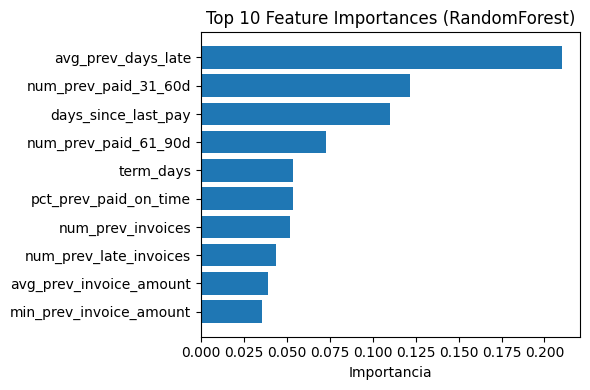

In [ ]:
imp = imp.sort_values('importance', ascending=True).tail(10)
plt.figure(figsize=(6,4))
plt.barh(imp['feature'], imp['importance'])
plt.title("Top 10 Feature Importances (RandomForest)")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

In [ ]:
# 1) Transforma tu X_test con el preprocesador (ya lo tienes)
X_test_proc = preprocessor.transform(X_test)

# 2) Extrae tu clasificador final
rf_clf = best_pipe_rf.named_steps['clf']

# 3) Calcula la importancia por permutación
perm = permutation_importance(
    rf_clf,
    X_test_proc,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# 4) Monta un DataFrame ordenado
feat_names = numeric_features + preprocessor.named_transformers_['cat'] \
                                    .get_feature_names_out(categorical_features).tolist()

perm_imp = pd.DataFrame({
    'feature': feat_names,
    'importance_mean': perm.importances_mean,
    'importance_std':  perm.importances_std
}).sort_values('importance_mean', ascending=False)

# 5) Muestra el top-10
print(perm_imp.head(10))

                    feature  importance_mean  importance_std
3        avg_prev_days_late         0.008643        0.000240
1                 term_days         0.006886        0.000339
14      days_since_last_pay         0.004597        0.000190
13    pct_prev_paid_on_time         0.004570        0.000110
6      num_prev_paid_61_90d         0.004487        0.000229
12     ratio_invoice_to_avg         0.001820        0.000239
0            invoice_amount         0.001722        0.000223
2         num_prev_invoices         0.001672        0.000223
54                  state_O         0.001097        0.000078
7   avg_prev_invoice_amount         0.001060        0.000182


Modelo reducido: podría bastar con las 7–10 primeras variables para mantener casi la misma performance.

Monitoreo dinámico:

Vigilar term_days, pct_prev_paid_on_time y days_since_last_pay en dashboards de riesgo.

Generar alerts automáticas si alguno de estos indicadores se deteriora bruscamente.

Política de crédito:

Ajustar límites o condiciones de pago según el “ratio” de la factura vs promedio histórico.

Priorizar revisiones manuales para facturas largas (largo plazo) y de importe excepcional.

## Prototype

In [ ]:
# 1) Lee el Excel y ya pon customer_id como índice de tipo string
df_clients = pd.read_excel(
    '/content/drive/MyDrive/ESPOL/TESIS/prototipoclientes.xlsx',
    dtype={'customer_id': str},    # fuerza a string al leer
    index_col='customer_id'        # lo convierte inmediatamente en índice
)
df_clients = df_clients.dropna(how='any')
df_clients["customer_group_code"] = df_clients["customer_group_code"].astype(str)

# 3) Echamos un vistazo rápido
display(df_clients.head())
df_clients.info()

,num_prev_invoices,avg_prev_days_late,num_prev_late_invoices,num_prev_paid_31_60d,num_prev_paid_61_90d,avg_prev_invoice_amount,stddev_prev_invoice_amount,min_prev_invoice_amount,max_prev_invoice_amount,days_since_last_invoice,ratio_invoice_to_avg,pct_prev_paid_on_time,days_since_last_pay,payment_terms_code,payment_method_code,customer_group_code,state
customer_id,,,,,,,,,,,,,,,,,
100008,9,56,9,1,0,134.486666,80663.862432,-113911.71,113911.71,412,847.011182,1.000000,385.0,ICO,GBG,107,SP
100090,2,54,2,0,0,12957.350000,18323.752996,0.50,25914.20,705,1.999961,1.000000,601.0,ICO,GBG,107,GU
100101,27,76,26,9,8,14722.000740,32555.772491,-56051.25,138933.76,32,9.437152,0.962963,208.0,ICO,GBG,107,NL
100105,17,52,15,10,4,40955.129411,82625.420617,14330.59,358214.75,23,8.746517,0.882353,28.0,45E,GBF,107,NB
100110,36,6,35,1,0,4.071111,3.879081,-7.08,13.22,49,3.247270,0.972222,48.0,ICO,GBF,107,NB


<class 'pandas.core.frame.DataFrame'>
Index: 1222 entries, 100008 to 297866
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   num_prev_invoices           1222 non-null   int64  
 1   avg_prev_days_late          1222 non-null   int64  
 2   num_prev_late_invoices      1222 non-null   int64  
 3   num_prev_paid_31_60d        1222 non-null   int64  
 4   num_prev_paid_61_90d        1222 non-null   int64  
 5   avg_prev_invoice_amount     1222 non-null   float64
 6   stddev_prev_invoice_amount  1222 non-null   float64
 7   min_prev_invoice_amount     1222 non-null   float64
 8   max_prev_invoice_amount     1222 non-null   float64
 9   days_since_last_invoice     1222 non-null   int64  
 10  ratio_invoice_to_avg        1222 non-null   float64
 11  pct_prev_paid_on_time       1222 non-null   float64
 12  days_since_last_pay         1222 non-null   float64
 13  payment_terms_code          122

---------------------------------------------------------------------------

In [ ]:
print("Listando archivos en", SAVE_DIR)
for root, dirs, files in os.walk(SAVE_DIR):
    print(f"\nEn {root}:")
    for f in files:
        print("  -", f)

Listando archivos en /content/drive/My Drive/PrototipoTesis/saved_models

En /content/drive/My Drive/PrototipoTesis/saved_models:
  - logistic_regression_20250702_064420.pkl
  - logistic_regression_20250702_071041.pkl
  - logistic_regression_20250708_135548.pkl
  - decision_tree_20250708_135601.pkl
  - random_forest_20250708_135650.pkl
  - logistic_regression_20250708_195342.pkl
  - decision_tree_20250708_195354.pkl
  - random_forest_20250708_195442.pkl
  - logistic_regression_20250709_061249.pkl
  - decision_tree_20250709_061302.pkl
  - random_forest_20250709_061353.pkl
  - logistic_regression_20250709_135448.pkl
  - decision_tree_20250709_135500.pkl
  - random_forest_20250709_135550.pkl
  - logistic_regression_20250709_143837.pkl
  - decision_tree_20250709_143850.pkl
  - random_forest_20250709_143941.pkl
  - logistic_regression_20250709_145019.pkl
  - decision_tree_20250709_145032.pkl
  - random_forest_20250709_145123.pkl
  - logistic_regression_20250709_160426.pkl
  - decision_tree_

In [ ]:
# 3) Listas de opciones SIN prefijos
payment_terms_choices = ["00K", "30F", "ICO"]
payment_method_choices = ["0", "00F", "00N", "ES4", "ESF", "GB5", "GBF", "GBG"]
customer_group_choices = ["100", "101", "102", "103", "104", "107", "199"]
state_choices = [
    "11","2","32","A","B","C","CH","CI","CR","D","E","F","G","H","I","IL",
    "L","M","MN","N","NB","O","P","R","S","SD","SE","T","TU","U","UT",
    "X","Y","Z"
]

In [ ]:
# —– Después de definir tus listas de choices —–
valid_terms   = set(payment_terms_choices)
valid_methods = set(payment_method_choices)
valid_groups  = set(customer_group_choices)
valid_states  = set(state_choices)

# Creamos una máscara que exige que TODAS las columnas categóricas sean “válidas”
mask = (
    df_clients["payment_terms_code"].isin(valid_terms) &
    df_clients["payment_method_code"].isin(valid_methods) &
    df_clients["customer_group_code"].isin(valid_groups) &
    df_clients["state"].isin(valid_states)
)

# Filtramos el DataFrame y regeneramos customer_ids
df_clients = df_clients.loc[mask]
customer_ids = df_clients.index.tolist()

In [ ]:
customer_ids = df_clients.index.tolist()

In [ ]:
pipe = joblib.load(
    '/content/drive/MyDrive/PrototipoTesis/saved_models/random_forest_20250728_141116.pkl'
)

In [ ]:
# 3) Función que trae la información relacionada al cliente según el customer_id
def fetch_stats(customer_id):
    row = df_clients.loc[customer_id]
    return (
    row["num_prev_invoices"],
    row["avg_prev_days_late"],
    row["num_prev_late_invoices"],
    row["num_prev_paid_31_60d"],
    row["num_prev_paid_61_90d"],
    row["avg_prev_invoice_amount"],
    #row["stddev_prev_invoice_amount"],
    row["min_prev_invoice_amount"],
    row["max_prev_invoice_amount"],
    row["days_since_last_invoice"],
    row["ratio_invoice_to_avg"],
    row["pct_prev_paid_on_time"],
    row["days_since_last_pay"],
    row["payment_terms_code"],
    row["payment_method_code"],
    row["customer_group_code"],
    row["state"]
    )

In [ ]:
def predict_default(
    invoice_amount,
    term_days,
    num_prev_invoices,
    avg_prev_days_late,
    num_prev_late_invoices,
    num_prev_paid_31_60d,
    num_prev_paid_61_90d,
    avg_prev_invoice_amount,
    #stddev_prev_invoice_amount,
    min_prev_invoice_amount,
    max_prev_invoice_amount,
    days_since_last_invoice,
    ratio_invoice_to_avg,
    pct_prev_paid_on_time,
    days_since_last_pay,
    payment_terms_code,
    payment_method_code,
    customer_group_code,
    state,
):
    try:
        row = {
            "invoice_amount":           invoice_amount,
            "term_days":                term_days,
            "num_prev_invoices":        num_prev_invoices,
            "avg_prev_days_late":       avg_prev_days_late,
            "num_prev_late_invoices":   num_prev_late_invoices,
            "num_prev_paid_31_60d":     num_prev_paid_31_60d,
            "num_prev_paid_61_90d":     num_prev_paid_61_90d,
            "avg_prev_invoice_amount":  avg_prev_invoice_amount,
            #"stddev_prev_invoice_amount": stddev_prev_invoice_amount,
            "min_prev_invoice_amount":  min_prev_invoice_amount,
            "max_prev_invoice_amount":  max_prev_invoice_amount,
            "days_since_last_invoice":  days_since_last_invoice,
            "ratio_invoice_to_avg":     ratio_invoice_to_avg,
            "pct_prev_paid_on_time":    pct_prev_paid_on_time,
            "days_since_last_pay":      days_since_last_pay,
            "payment_terms_code":       payment_terms_code,
            "payment_method_code":      payment_method_code,
            "customer_group_code":      customer_group_code,
            "state":                    state,
        }
        df = pd.DataFrame([row])

        pred  = pipe.predict(df)[0]
        proba = pipe.predict_proba(df)[0][1]


        return int(pred), round(float(proba), 4)
    except Exception as e:
        # devuelve el mensaje y el stacktrace para verlo en la UI
        return f"ERROR: {e}", traceback.format_exc()

In [ ]:
# 4) Interfaz con Blocks para actualización automática
with gr.Blocks(
    title="🔮 Prototipo: Predicción de Incobrabilidad",
    css="""
        .gradio-container { max-width: 900px; margin: auto; }
        h1, h2 { text-align: center; }
        .section { margin-bottom: 2rem; }
    """
) as demo:

# Título centrado
    gr.Markdown("# 🔮 Predicción de Incobrabilidad\n"
                "Selecciona un cliente, ajusta la nueva factura y obtén tu predicción.")

    # Row con dos columnas
    with gr.Row(equal_height=True):
        # Columna 1: Parámetros de factura
        with gr.Column(scale=1):
            gr.Markdown("## Parámetros de la factura", elem_classes="section")
            invoice_amount = gr.Number(label="Monto factura", interactive=True)
            term_days      = gr.Number(label="Días de vencimiento",
                                       interactive=True, precision=0, step=1, minimum=1)
            predict_btn    = gr.Button("🔮 Predecir incobrabilidad")

        with gr.Column(scale=2):
            gr.Markdown("## Estadísticas históricas", elem_classes="section")
            dropdown               = gr.Dropdown(choices=customer_ids, label="Cliente")
            prev_inv               = gr.Number(label="Facturas emitidas",        interactive=True)
            avg_prev_days_late     = gr.Number(label="Promedio de días vencido",       interactive=True)
            prev_late              = gr.Number(label="Facturas vencidas",   interactive=True)
            prev_paid_31_60d       = gr.Number(label="Facturas pagadas entre 31 y 60 días",     interactive=True)
            prev_paid_61_90d       = gr.Number(label="Facturas pagadas entre 61 y 90 días",     interactive=True)
            avg_prev_invoice_amount= gr.Number(label="Promedio de monto de factura",  interactive=True)
            #stddev_prev_invoice_amount = gr.Number(label="Desv estándar de monto de factura", interactive=True)
            min_prev_invoice_amount= gr.Number(label="Monto mínimo de factura",  interactive=True)
            max_prev_invoice_amount= gr.Number(label="Monto máximo de factura",  interactive=True)
            days_since_last_invoice= gr.Number(label="Días sin comprar",  interactive=True)
            ratio_invoice_to_avg   = gr.Number(label="Ratio factura vs promedio histórico",     interactive=True)
            pct_prev_paid_on_time  = gr.Number(label="% pago a tiempo",    interactive=True)
            days_since_last_pay    = gr.Number(label="Días desde el último cobro",      interactive=True)
            payment_terms_code     = gr.Dropdown(choices=payment_terms_choices,  label="Término de pago",  interactive=True)
            payment_method_code    = gr.Dropdown(choices=payment_method_choices, label="Método de pago", interactive=True)
            customer_group_code    = gr.Dropdown(choices=customer_group_choices, label="Grupo de cliente", interactive=True)
            state                  = gr.Dropdown(choices=state_choices,          label="Ubicación",               interactive=True)

    # — Zona de resultados —
    with gr.Row(equal_height=True):
        prediction  = gr.Label(label="Predicción (0=Pago, 1=Incobrable)")
        probability = gr.Textbox(label="Probabilidad de impago (%)", interactive=False)


    dropdown.change(
        fn=fetch_stats,
        inputs=dropdown,
        outputs=[
            prev_inv,
            prev_late,
            avg_prev_days_late,
            prev_paid_31_60d,
            prev_paid_61_90d,
            avg_prev_invoice_amount,
           # stddev_prev_invoice_amount,
            min_prev_invoice_amount,
            max_prev_invoice_amount,
            days_since_last_invoice,
            ratio_invoice_to_avg,
            pct_prev_paid_on_time,
            days_since_last_pay,
            payment_terms_code,
            payment_method_code,
            customer_group_code,
            state
        ]
    )


    predict_btn.click(
        fn=predict_default,
        inputs=[
            invoice_amount,
            term_days,
            prev_inv,
            avg_prev_days_late,
            prev_late,
            prev_paid_31_60d,
            prev_paid_61_90d,
            avg_prev_invoice_amount,
            #stddev_prev_invoice_amount,
            min_prev_invoice_amount,
            max_prev_invoice_amount,
            days_since_last_invoice,
            ratio_invoice_to_avg,
            pct_prev_paid_on_time,
            days_since_last_pay,
            payment_terms_code,
            payment_method_code,
            customer_group_code,
            state,
        ],
        outputs=[prediction, probability],
    )

if __name__ == "__main__":
    demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fba332800d80d82161.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


---------------------------------------------------------------------------------------------------------------------------